# Heatmap Visualization

#### Imports and settings

In [25]:
import os, glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# default style
sns.set(style="white")
plt.rcParams["figure.dpi"] = 120

#### Collect p-values from every .csv

In [26]:
BASE_DIR  = "../../data/processed"
SUBDIRS   = ["successes", "failures", "misfits"]   # look inside each one
SEP       = "_"                                    # filename separator between tickers

pair_pvals = {}        # {(T1,T2): p}
tickers    = set()

for sub in SUBDIRS:
    pattern = os.path.join(BASE_DIR, sub, "*.csv")
    for path in glob.glob(pattern):
        name      = os.path.splitext(os.path.basename(path))[0]
        try:
            t1, t2 = name.split(SEP)
        except ValueError:
            print(f"Skipping {name} (unexpected filename format)")
            continue
        
        pval = pd.read_csv(path)["P-value"].iloc[0]    # constant column
        pair_pvals[(t1, t2)] = pval
        pair_pvals[(t2, t1)] = pval                    # make matrix symmetric
        tickers.update([t1, t2])

tickers = sorted(tickers)
print(f"Found {len(pair_pvals)//2} unique pairs across {len(tickers)} tickers.")

Found 406 unique pairs across 29 tickers.


#### Build the square df

In [27]:
# Start with NaNs so missing combos stay blank
mat = pd.DataFrame(
    np.nan,
    index=tickers,
    columns=tickers,
    dtype=float,
)

for (i, j), p in pair_pvals.items():
    mat.loc[i, j] = p

# (Optional) set diagonal to 0 so the palette shows full green
np.fill_diagonal(mat.values, 0.0)

#### Plot the heatmap

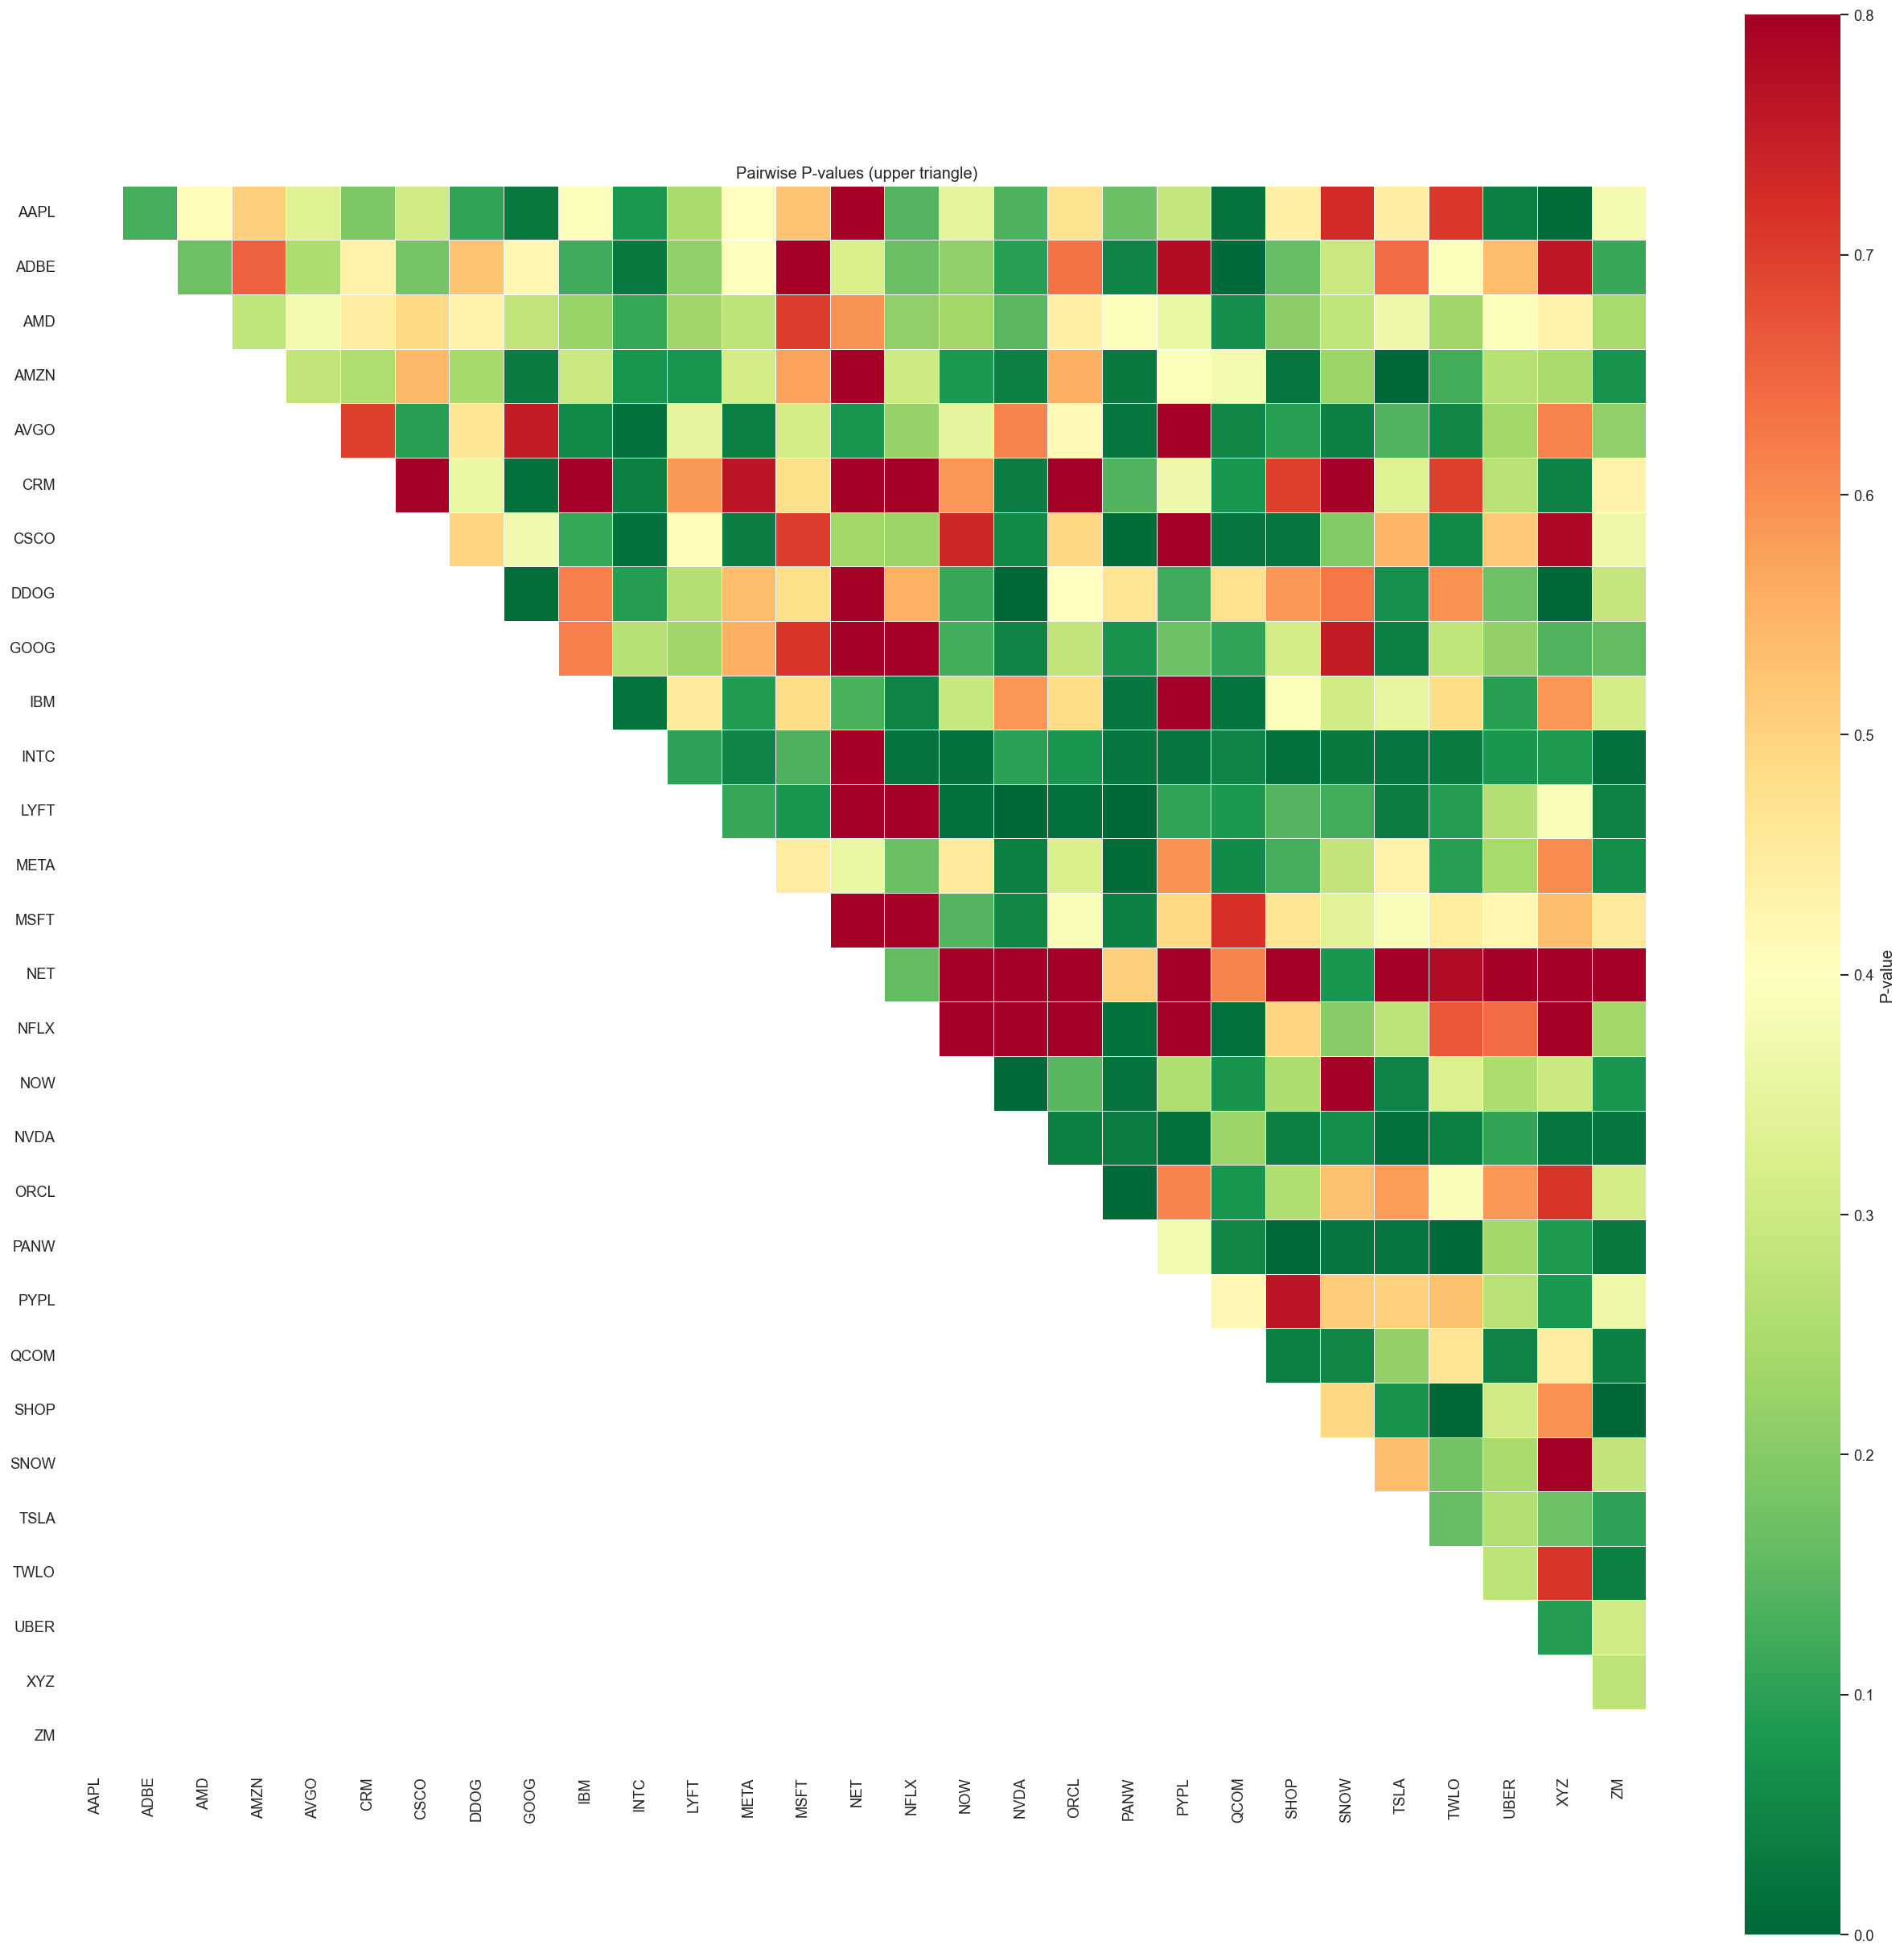

In [28]:
mask = np.tril(np.ones_like(mat, dtype=bool))      # hide LOWER triangle
cmap = sns.color_palette("RdYlGn_r", as_cmap=True) # 0 → green, 0.8 → red

plt.figure(figsize=(0.6*len(tickers)+4, 0.6*len(tickers)+3))
sns.heatmap(
    mat,
    cmap=cmap,
    vmin=0, vmax=0.8,
    annot=False,                  # <-- remove the text
    linewidths=.5, linecolor="white",
    square=True,
    mask=mask,                    # <-- now we mask the bottom half
    cbar_kws={"label": "P-value"},
)
plt.title("Pairwise P-values (upper triangle)")
plt.tight_layout()
plt.show()
